#### ETUDES SPATIALES DES VARIABLES PRINCIPALES

In [183]:
data_weather <- read.table("data/donnees-synop-essentielles-omm.csv",
                        header=TRUE,
                        sep=";",
                        quote = "\"") # treat text inside "..." as a single field, even if it contains ;

In [367]:
# Loading background maps and other modules
library(maps) 
library(RColorBrewer)
library(mapproj)
library(lubridate)
library(dplyr)
library(clue)

In [185]:
# Sorting by ascending date
data_weather <- data_weather[order(data_weather$Date),]
rownames(data_weather) <- NULL

In [ ]:
# Building the used data frame
selected_data_maps <- data_weather[, c(2,3,7,8,10,40,71,72)]
colnames(selected_data_maps)

# Removing NA values
selected_data_maps <- na.omit(selected_data_maps)

# Rounding the Latitude & Longitude 
selected_data_maps$Latitude <- round(selected_data_maps$Latitude, 5)
selected_data_maps$Longitude <- round(selected_data_maps$Longitude, 5)

# Keeping the values from stations in metropolitan France (meaning Lat in 41/51 & Lon in -6/10)
selected_data_maps <- selected_data_maps[selected_data_maps$Latitude >= 41 & 
                            selected_data_maps$Latitude <= 51 &
                            selected_data_maps$Longitude >= -6 &
                            selected_data_maps$Longitude <= 10, ]

[1] "Date"                                      
[2] "Pression.au.niveau.mer"                    
[3] "Vitesse.du.vent.moyen.10.mn"               
[4] "Température"                               
[5] "Humidité"                                  
[6] "Précipitations.dans.les.3.dernières.heures"
[7] "Latitude"                                  
[8] "Longitude"

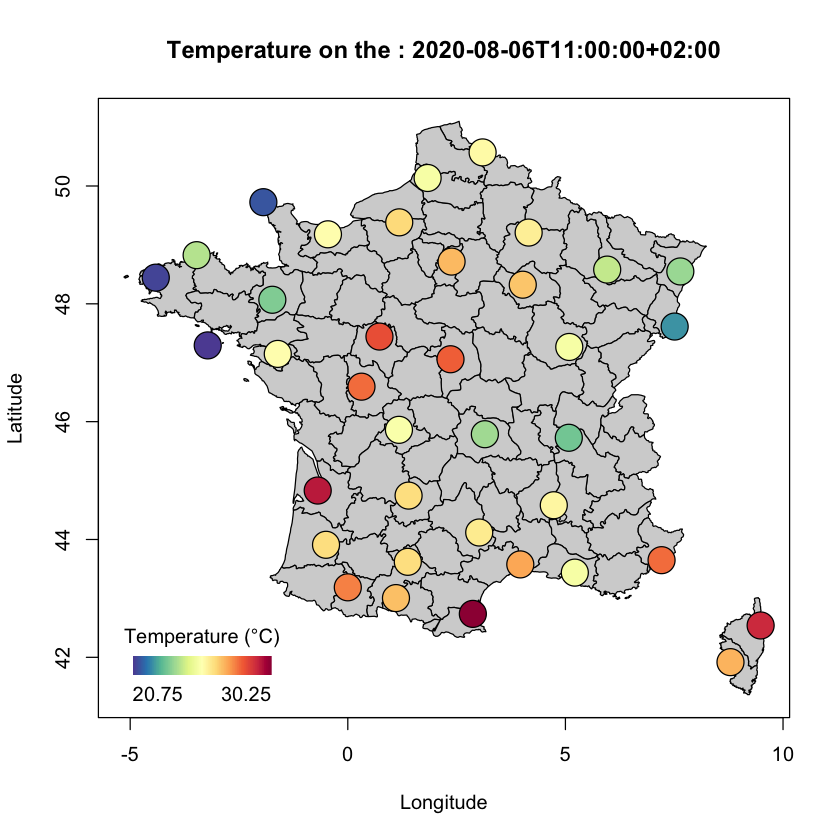

In [ ]:
# Graph punctual
date <- "2020-08-06T11:00:00+02:00"
subset_data <- selected_data_maps[selected_data_maps$Date == date,]

# Colors for gradient
pal <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
n_colors <- 200
colors <- pal(n_colors)

# Converting the data in color (here temperature) - don't forget to remove NA values
temp_range <- range(subset_data$Température)
color_index <- round((subset_data$Température - temp_range[1]) / 
                     (temp_range[2] - temp_range[1]) * (n_colors - 1)) + 1

# Loading the french map
france_df <- map_data("france")

# Plotting
par(bg = "white")

plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("Temperature on the :", date)) # Outline
groups <- unique(france_df$group) # Regions
for(g in groups) {
  sub <- france_df[france_df$group == g, ]
  polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
}

points(subset_data$Longitude, subset_data$Latitude, bg = colors[color_index], col = "black", pch = 21, cex = 3) # Points


# Adding the legend 
usr <- par("usr")  # c(xmin, xmax, ymin, ymax)

# Positioning the gradient in the bottom left 
x0 <- usr[1] + 0.05 * (usr[2] - usr[1])
x1 <- usr[1] + 0.25 * (usr[2] - usr[1])
y0 <- usr[3] + 0.05 * (usr[4] - usr[3]) + 0.2
y1 <- usr[3] + 0.08 * (usr[4] - usr[3]) + 0.2

# Colors
n_leg <- n_colors
leg_colors <- colors[1:n_leg]
temp_seq <- seq(min(subset_data$Température), max(subset_data$Température), length.out = n_leg)

# Gradient
dx <- (x1 - x0)/n_leg
for(i in 1:n_leg){
  rect(x0 + (i-1)*dx, y0, x0 + i*dx, y1, col = leg_colors[i], border = NA)
}

# Adding labels
text(x0, y0 - 0.03*(usr[4]-usr[3]), round(min(temp_seq),1) - 273.15, adj=0)
text(x1, y0 - 0.03*(usr[4]-usr[3]), round(max(temp_seq),1) - 273.15, adj=1)
text((x0+x1)/2, y1 + 0.03*(usr[4]-usr[3]), "Temperature (°C)", adj=0.5)


#### Explanation
- What question am I asking about the data? What do I want to illustrate?
    - In this section, we want to see and illustrate the spatial distribution of the data (where are the different stations, is the distribution homogeneous, ...). 
- Why is the method I am going to use relevant?
    - To do so we choose a fix time and a measurement to plot. In that case we show the temperature on the 2020-08-06 at 11 AM, using a color gradient. To be noticed, there's some extra data from stations not in metropolitan France. In the following maps we've removed it to ensure a consistency to the color gradient (indeed there's a station in Antarctica which drives temperature values down for example.)
- What conclusions do I draw from it?
    - Clearly we have an homogeneous distribution of the station which is nice to understand more generally the overall climate in France. Then looking at the measurement (in this case temperature at a given date), we can see a clear disparity depending on north/south distribution, but also on the different climate (Oceanic, Mediterranean, Semi-Continental, Mountainous).
- What are the possible limitations of what I am proposing?
    - For now, only looking at the temperature at a given date doesn't mean much, we can't really interpret those results (climate vs weather ...). In the next part we'll focus again on temperatures but averaging over day, season, year ...

`summarise()` has grouped output by 'Latitude'. You can override using the
`.groups` argument.


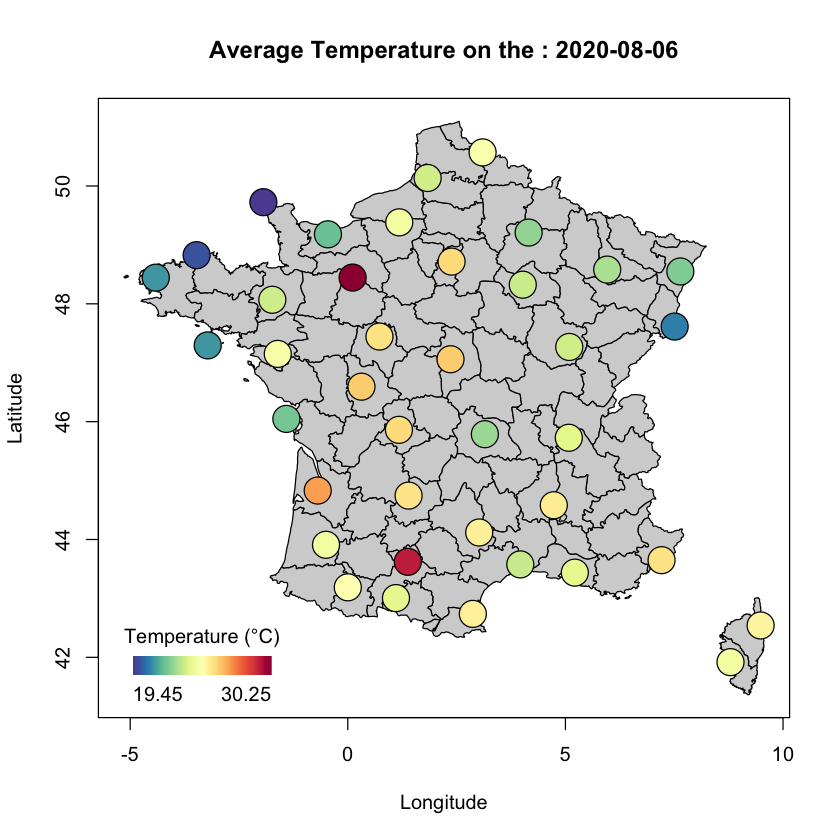

In [ ]:
# Graph average temperature over a day
date <- "2020-08-06"
up_to_date_data <- selected_data_maps[as_date(selected_data_maps$Date) == as_date(date), ]
measures_col <- c("Température")
leftover_col <- c("Date", "Latitude", "Longitude")

# First grouping the up to date data by station, then using summarise computing the mean and only keeping one date (cause they're all the same)
library(dplyr)
subset_data <- as.data.frame(up_to_date_data %>% group_by(Latitude, Longitude) %>% summarise(across(all_of(measures_col), mean), Date = first(Date)))

# Colors for gradient
pal <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
n_colors <- 200
colors <- pal(n_colors)

# Converting the data in color (here temperature) - don't forget to remove NA values
temp_range <- range(subset_data$Température)
color_index <- round((subset_data$Température - temp_range[1]) / 
                     (temp_range[2] - temp_range[1]) * (n_colors - 1)) + 1

# Loading the french map
france_df <- map_data("france")

# Plotting
par(bg = "white")

plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("Average Temperature on the :", date)) # Outline
groups <- unique(france_df$group) # Regions
for(g in groups) {
  sub <- france_df[france_df$group == g, ]
  polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
}

points(subset_data$Longitude, subset_data$Latitude, bg = colors[color_index], col = "black", pch = 21, cex = 3) # Points

# Adding the legend 
usr <- par("usr")  # c(xmin, xmax, ymin, ymax)

# Positioning the gradient in the bottom left 
x0 <- usr[1] + 0.05 * (usr[2] - usr[1])
x1 <- usr[1] + 0.25 * (usr[2] - usr[1])
y0 <- usr[3] + 0.05 * (usr[4] - usr[3]) + 0.2
y1 <- usr[3] + 0.08 * (usr[4] - usr[3]) + 0.2

# Colors
n_leg <- n_colors
leg_colors <- colors[1:n_leg]
temp_seq <- seq(min(subset_data$Température), max(subset_data$Température), length.out = n_leg)

# Gradient
dx <- (x1 - x0)/n_leg
for(i in 1:n_leg){
  rect(x0 + (i-1)*dx, y0, x0 + i*dx, y1, col = leg_colors[i], border = NA)
}

# Adding labels
text(x0, y0 - 0.03*(usr[4]-usr[3]), round(min(temp_seq),1) - 273.15, adj=0)
text(x1, y0 - 0.03*(usr[4]-usr[3]), round(max(temp_seq),1) - 273.15, adj=1)
text((x0+x1)/2, y1 + 0.03*(usr[4]-usr[3]), "Temperature (°C)", adj=0.5)

#### Explanation
- What question am I asking about the data? What do I want to illustrate?
    - We now want to show the spatial distribution of daily mean temperatures across France. This should smooths out hourly fluctuations and highlights regional patterns.
- Why is the method I am going to use relevant?
    - Averaging over a day (in our case 2020-08-06) reduces short-term noise. Again, plotting stations on a map with a color gradient reveals both station coverage and regional temperature differences. 
- What conclusions do I draw from it?
    - The map shows clear north-south and altitudinal gradients, with colder temperatures in oceanic, mountainous regions and warmer in the south. Nevertheless we seems to have to interesting points due to regional variations : in south Alsace we have a colder day, and one near Le Mans where we see a huge average (maybe due to an heat wave). And finally we can see again France’s main climate zones as describe earlier.
- What are the possible limitations of what I am proposing?
    - Daily averages can still be influenced by short-term weather events. They do not capture seasonal or yearly trends, nor other climatic factors like precipitation or wind, that will be cover later.

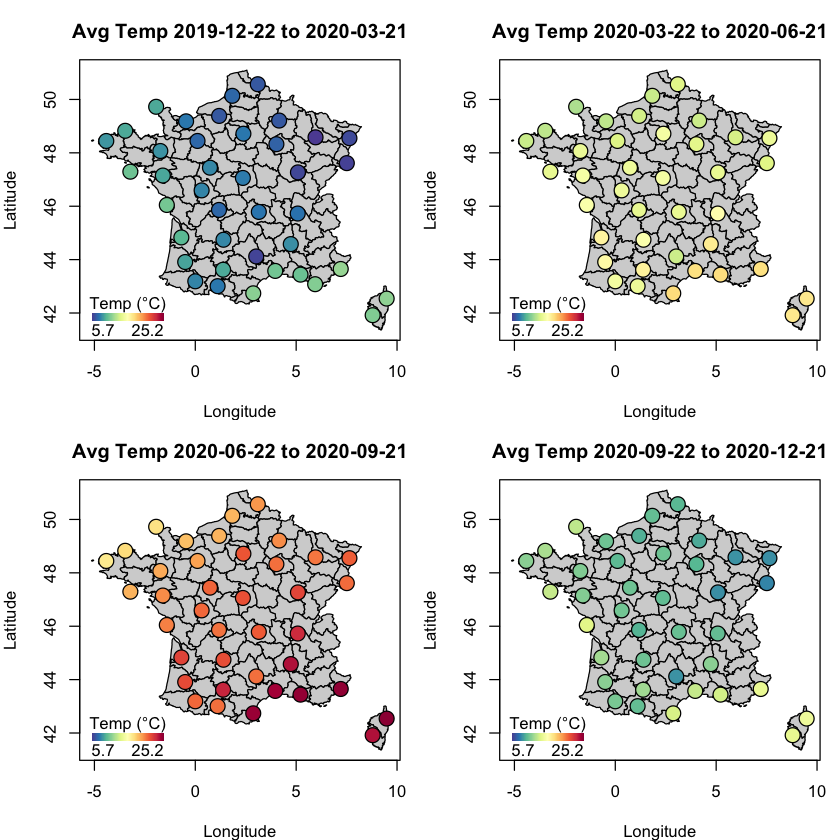

In [ ]:
# Graph average temperature over the seasons
dates <- list(
  c("2019-12-22", "2020-03-21"),
  c("2020-03-22", "2020-06-21"),
  c("2020-06-22", "2020-09-21"),
  c("2020-09-22", "2020-12-21")
)

# Colors for gradient
pal <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
n_colors <- 200
colors <- pal(n_colors)

# Loading the french map
france_df <- map_data("france")
groups <- unique(france_df$group)

# Initialization of a memory
season_subset_data <- list()
measures_col <- c("Température")

# Computing the data for each seasons
for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Filtering for this season
  up_to_date_data <- selected_data_maps[as_date(selected_data_maps$Date) >= as_date(date_inf) & as_date(selected_data_maps$Date) <= as_date(date_sup), ]

  # First grouping the up to date data by station, then using summarise computing the mean and only keeping one date (cause they're all the same
  subset_data <- as.data.frame(up_to_date_data %>% group_by(Latitude, Longitude) %>% summarise(across(all_of(measures_col), mean), Date = first(Date), .groups = "drop"))
  season_subset_data[[i]] <- subset_data
}

# Building the color legend to have a common scale for the 4 plots
temp_range <- range(unlist(lapply(season_subset_data, function(df) df$Température)))

# Colors for the legend
n_leg <- n_colors
leg_colors <- colors[1:n_leg]
temp_seq <- seq(min(temp_range), max(temp_range), length.out = n_leg)

# Plotting
par(mfrow = c(2,2), bg = "white", mar = c(4,4,3,1))

for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Loading the subset
  subset_data <- season_subset_data[[i]]

  # Associating a color to each data
  color_index <- round((subset_data$Température - temp_range[1]) / 
                     (temp_range[2] - temp_range[1]) * (n_colors - 1)) + 1

  # Plotting France and points
  plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("Avg Temp", date_inf, "to", date_sup)) # Outline 
  for(g in groups) { # Regions
    sub <- france_df[france_df$group == g, ]
    polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
  }

  points(subset_data$Longitude, subset_data$Latitude, bg = colors[color_index], col = "black", pch = 21, cex = 2) # Points

  # Adding the legend 
  usr <- par("usr")  # c(xmin, xmax, ymin, ymax)

  # Positioning the gradient in the bottom left 
  x0 <- usr[1] + 0.05 * (usr[2] - usr[1]) - 0.2
  x1 <- usr[1] + 0.25 * (usr[2] - usr[1]) + 0.2
  y0 <- usr[3] + 0.05 * (usr[4] - usr[3]) + 0.2
  y1 <- usr[3] + 0.08 * (usr[4] - usr[3]) + 0.2

  # Gradient
  dx <- (x1 - x0)/n_leg
  for(i in 1:n_leg){
    rect(x0 + (i-1)*dx, y0, x0 + i*dx, y1, col = leg_colors[i], border = NA)
  }

  # Adding labels
  text(x0, y0 - 0.03*(usr[4]-usr[3]), round(min(temp_seq) - 273.15,1), adj=0)
  text(x1, y0 - 0.03*(usr[4]-usr[3]), round(max(temp_seq) - 273.15,1), adj=1)
  text((x0+x1)/2, y1 + 0.03*(usr[4]-usr[3]), "Temp (°C)", adj=0.5)
}

#### Explanation
- What question am I asking about the data? What do I want to illustrate?
    - We aim to visualize how average temperatures vary across France for each season. Using the four subplots allows us to compare spatial patterns and seasonal differences simultaneously. Starting from top left, we plot winter, spring, summer, fall.
- Why is the method I am going to use relevant?
    - Averaging temperatures over a season smooths out daily fluctuations and highlights general climate patterns. Subplots make it easy to see changes from winter to summer and across different regions.
- What conclusions do I draw from it?
    - A clear north-south temperature gradient is visible in almost all seasons (especially in winter, summer and fall), with colder regions in the north, near the atlantic ocean and mountainous areas. Summer shows the highest temperatures in the south, while winter highlights colder zones, especially in the east due to its semi-continental climate. Station coverage is sufficiently homogeneous, so the spatial representation is reliable.
- What are the possible limitations of what I am proposing?
    - Seasonal averages hide daily extremes and short-term weather events, so these maps reflect climate trends rather than specific weather.
    

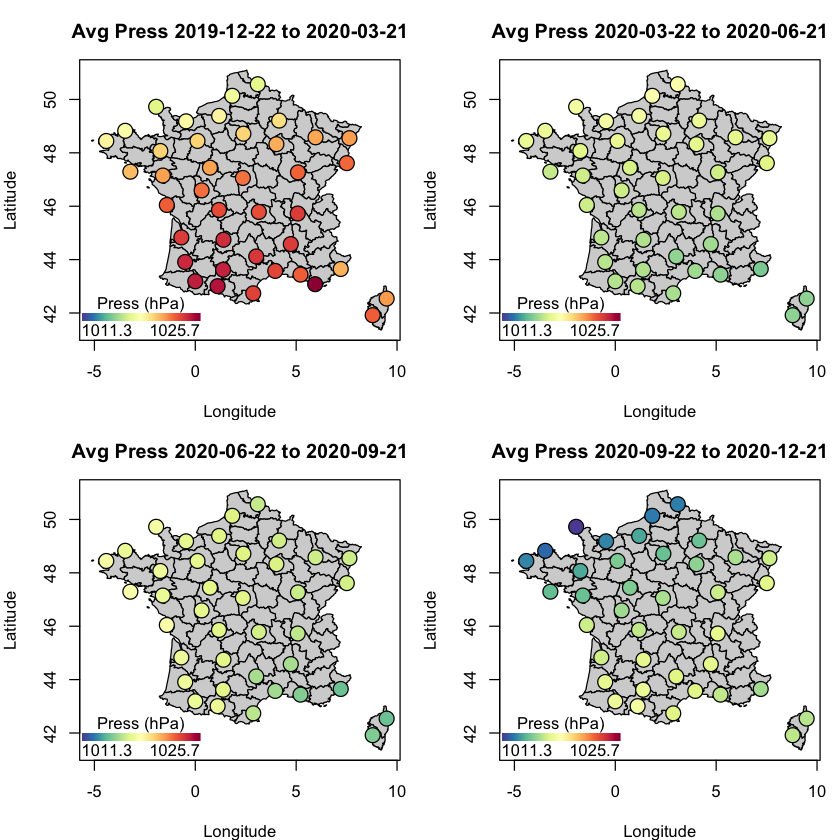

In [ ]:
# Graph average pressure over the seasons
dates <- list(
  c("2019-12-22", "2020-03-21"),
  c("2020-03-22", "2020-06-21"),
  c("2020-06-22", "2020-09-21"),
  c("2020-09-22", "2020-12-21")
)

# Colors for gradient
pal <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
n_colors <- 200
colors <- pal(n_colors)

# Loading the french map
france_df <- map_data("france")
groups <- unique(france_df$group)

# Initialization of a memory
season_subset_data <- list()
measures_col <- c("Pression.au.niveau.mer")

# Computing the data for each seasons
for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Filtering for this season
  up_to_date_data <- selected_data_maps[as_date(selected_data_maps$Date) >= as_date(date_inf) & as_date(selected_data_maps$Date) <= as_date(date_sup), ]

  # First grouping the up to date data by station, then using summarise computing the mean and only keeping one date (cause they're all the same
  subset_data <- as.data.frame(up_to_date_data %>% group_by(Latitude, Longitude) %>% summarise(across(all_of(measures_col), mean), Date = first(Date), .groups = "drop"))
  season_subset_data[[i]] <- subset_data
}

# Building the color legend to have a common scale for the 4 plots
press_range <- range(unlist(lapply(season_subset_data, function(df) df$Pression.au.niveau.mer/100)))

# Colors for the legend
n_leg <- n_colors
leg_colors <- colors[1:n_leg]
press_seq <- seq(min(press_range), max(press_range), length.out = n_leg)

# Plotting
par(mfrow = c(2,2), bg = "white", mar = c(4,4,3,1))

for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Loading the subset
  subset_data <- season_subset_data[[i]]

  # Associating a color to each data
  color_index <- round((subset_data$Pression.au.niveau.mer/100 - press_range[1]) / 
                     (press_range[2] - press_range[1]) * (n_colors - 1)) + 1

  # Plotting France and points
  plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("Avg Press", date_inf, "to", date_sup)) # Outline 
  for(g in groups) { # Regions
    sub <- france_df[france_df$group == g, ]
    polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
  }

  points(subset_data$Longitude, subset_data$Latitude, bg = colors[color_index], col = "black", pch = 21, cex = 2) # Points

  # Adding the legend 
  usr <- par("usr")  # c(xmin, xmax, ymin, ymax)

  # Positioning the gradient in the bottom left 
  x0 <- usr[1] + 0.05 * (usr[2] - usr[1]) - 0.7
  x1 <- usr[1] + 0.25 * (usr[2] - usr[1]) + 2
  y0 <- usr[3] + 0.05 * (usr[4] - usr[3]) + 0.2
  y1 <- usr[3] + 0.08 * (usr[4] - usr[3]) + 0.2

  # Gradient
  dx <- (x1 - x0)/n_leg
  for(i in 1:n_leg){
    rect(x0 + (i-1)*dx, y0, x0 + i*dx, y1, col = leg_colors[i], border = NA)
  }

  # Adding labels
  text(x0, y0 - 0.03*(usr[4]-usr[3]), round(min(press_seq),1), adj=0)
  text(x1, y0 - 0.03*(usr[4]-usr[3]), round(max(press_seq),1), adj=1)
  text((x0+x1)/2, y1 + 0.03*(usr[4]-usr[3]), "Press (hPa)", adj=0.5)
}

#### Explanation
- What question am I asking about the data? What do I want to illustrate?
    - We now want to visualize how average atmospheric pressure varies across France for each season. The four subplots allow comparison of spatial pressure patterns throughout the year.
- Why is the method I am going to use relevant?
    - This method should reveal general trends and regional differences. We should be able to see clear high and low-pressure area. 
- What conclusions do I draw from it?
    - The maps show relatively homogeneous pressure values across France during each season. Nevertheless looking at the map during winter, we clearly see a global rise in the pressure which is due to air temperature, hot air tend to rise while cold air stay low. We also have the following hypothesis, during winter and fall there's a clear trend, pressure is rising as we travel inland from the northern Atlantic coast. This could be explain by the buffer effect of the ocean, keeping a stable temperature and therefore warming up the costs with respect to the inside of the land.
- What are the possible limitations of what I am proposing?
    - This map used the pressure at sea level, which (according to our hypotheses) is computed using a modelling of the atmosphere and the real pressure measurement at the station. We've made this choice to have consistent data spatially, but the atmosphere level could be one limitation.

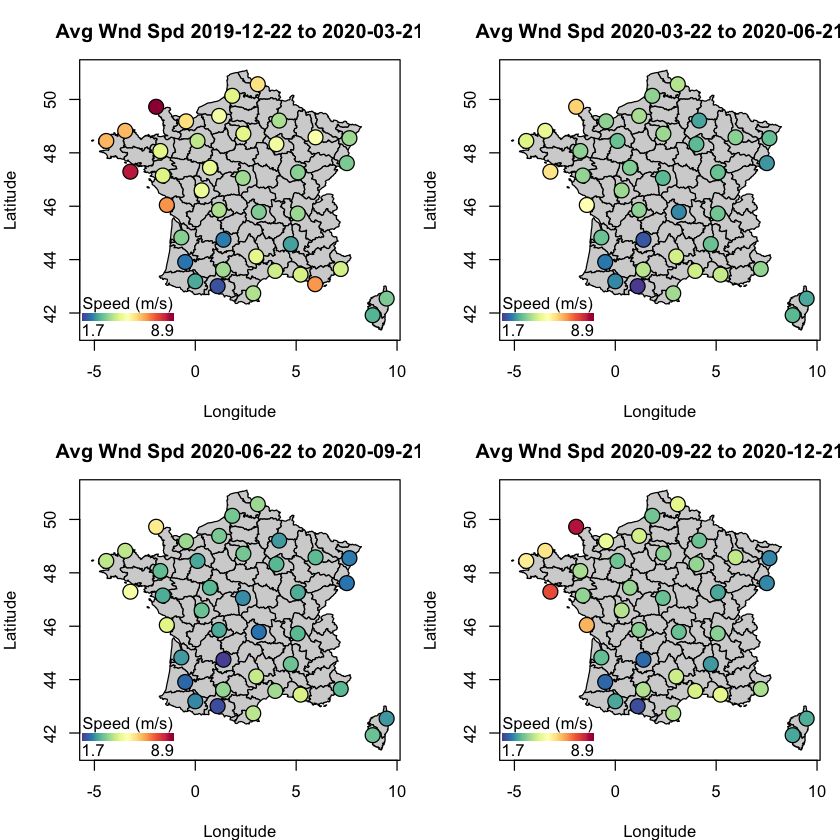

In [ ]:
# Graph average wind speed over the seasons
dates <- list(
  c("2019-12-22", "2020-03-21"),
  c("2020-03-22", "2020-06-21"),
  c("2020-06-22", "2020-09-21"),
  c("2020-09-22", "2020-12-21")
)

# Colors for gradient
pal <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
n_colors <- 200
colors <- pal(n_colors)

# Loading the french map
france_df <- map_data("france")
groups <- unique(france_df$group)

# Initialization of a memory
season_subset_data <- list()
measures_col <- c("Vitesse.du.vent.moyen.10.mn")

# Computing the data for each seasons
for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Filtering for this season
  up_to_date_data <- selected_data_maps[as_date(selected_data_maps$Date) >= as_date(date_inf) & as_date(selected_data_maps$Date) <= as_date(date_sup), ]

  # First grouping the up to date data by station, then using summarise computing the mean and only keeping one date (cause they're all the same
  subset_data <- as.data.frame(up_to_date_data %>% group_by(Latitude, Longitude) %>% summarise(across(all_of(measures_col), mean), Date = first(Date), .groups = "drop"))
  season_subset_data[[i]] <- subset_data
}

# Building the color legend to have a common scale for the 4 plots
wind_range <- range(unlist(lapply(season_subset_data, function(df) df$Vitesse.du.vent.moyen.10.mn)))

# Colors for the legend
n_leg <- n_colors
leg_colors <- colors[1:n_leg]
wind_seq <- seq(min(wind_range), max(wind_range), length.out = n_leg)

# Plotting
par(mfrow = c(2,2), bg = "white", mar = c(4,4,3,1))

for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Loading the subset
  subset_data <- season_subset_data[[i]]

  # Associating a color to each data
  color_index <- round((subset_data$Vitesse.du.vent.moyen.10.mn - wind_range[1]) / 
                     (wind_range[2] - wind_range[1]) * (n_colors - 1)) + 1

  # Plotting France and points
  plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("Avg Wnd Spd", date_inf, "to", date_sup)) # Outline 
  for(g in groups) { # Regions
    sub <- france_df[france_df$group == g, ]
    polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
  }

  points(subset_data$Longitude, subset_data$Latitude, bg = colors[color_index], col = "black", pch = 21, cex = 2) # Points

  # Adding the legend 
  usr <- par("usr")  # c(xmin, xmax, ymin, ymax)

  # Positioning the gradient in the bottom left 
  x0 <- usr[1] + 0.05 * (usr[2] - usr[1]) - 0.7
  x1 <- usr[1] + 0.25 * (usr[2] - usr[1]) + 0.7
  y0 <- usr[3] + 0.05 * (usr[4] - usr[3]) + 0.2
  y1 <- usr[3] + 0.08 * (usr[4] - usr[3]) + 0.2

  # Gradient
  dx <- (x1 - x0)/n_leg
  for(i in 1:n_leg){
    rect(x0 + (i-1)*dx, y0, x0 + i*dx, y1, col = leg_colors[i], border = NA)
  }

  # Adding labels
  text(x0, y0 - 0.03*(usr[4]-usr[3]), round(min(wind_seq),1), adj=0)
  text(x1, y0 - 0.03*(usr[4]-usr[3]), round(max(wind_seq),1), adj=1)
  text((x0+x1)/2, y1 + 0.03*(usr[4]-usr[3]), "Speed (m/s)", adj=0.5)
}

#### Explanation
- What question am I asking about the data? What do I want to illustrate?
    - We want to analyze the spatial and seasonal distribution of wind speeds across France, and see how wind intensity varies depending on geography and season.
- Why is the method I am going to use relevant?
    - Again averaging measurement over a season smooths out daily fluctuations and this map helps highlight regions where wind is systematically stronger like coasts compared to calmer inland areas.
- What conclusions do I draw from it?
    - We observe stronger winds along the Atlantic and Mediterranean coasts, while inland plains generally experience lower average speeds and mountains regions (such as the Pyrenees) even less wind. Seasonal differences can also be detected, with higher winds in fall and winter which matches with the pressure differences we observed earlier. Therefore region with stronger pressure gradients correspond directly to areas with higher average winds, illustrating the physical link between atmospheric pressure and wind intensity.
- What are the possible limitations of what I am proposing?
    - One limitation could be that wind is strongly influenced by topography, and plotting this map we didn't took into account such information. Also, using the mean may be less relevant than looking at maximum wind speeds (which will be done next), since extremes event are what matter most for concrete impacts (we will later take the example of agriculture for example).

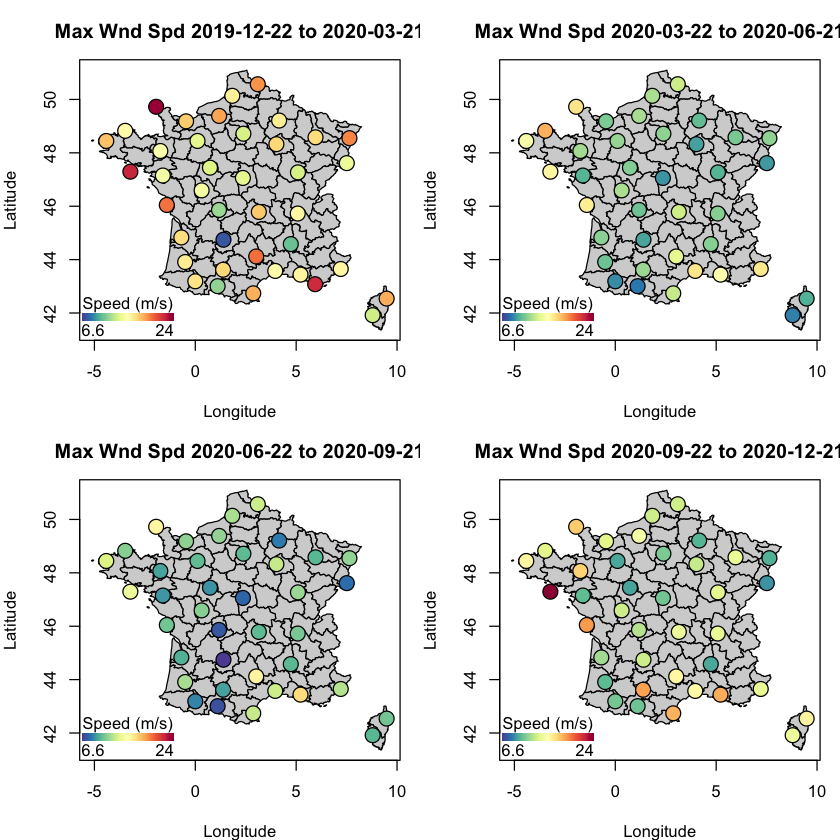

In [ ]:
# Graph max wind speed over the seasons
dates <- list(
  c("2019-12-22", "2020-03-21"),
  c("2020-03-22", "2020-06-21"),
  c("2020-06-22", "2020-09-21"),
  c("2020-09-22", "2020-12-21")
)

# Colors for gradient
pal <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
n_colors <- 200
colors <- pal(n_colors)

# Loading the french map
france_df <- map_data("france")
groups <- unique(france_df$group)

# Initialization of a memory
season_subset_data <- list()
measures_col <- c("Vitesse.du.vent.moyen.10.mn")

# Computing the data for each seasons
for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Filtering for this season
  up_to_date_data <- selected_data_maps[as_date(selected_data_maps$Date) >= as_date(date_inf) & as_date(selected_data_maps$Date) <= as_date(date_sup), ]

  # First grouping the up to date data by station, then using summarise computing the mean and only keeping one date (cause they're all the same
  subset_data <- as.data.frame(up_to_date_data %>% group_by(Latitude, Longitude) %>% summarise(across(all_of(measures_col), max), Date = first(Date), .groups = "drop"))
  season_subset_data[[i]] <- subset_data
}

# Building the color legend to have a common scale for the 4 plots
wind_range <- range(unlist(lapply(season_subset_data, function(df) df$Vitesse.du.vent.moyen.10.mn)))

# Colors for the legend
n_leg <- n_colors
leg_colors <- colors[1:n_leg]
wind_seq <- seq(min(wind_range), max(wind_range), length.out = n_leg)

# Plotting
par(mfrow = c(2,2), bg = "white", mar = c(4,4,3,1))

for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Loading the subset
  subset_data <- season_subset_data[[i]]

  # Associating a color to each data
  color_index <- round((subset_data$Vitesse.du.vent.moyen.10.mn - wind_range[1]) / 
                     (wind_range[2] - wind_range[1]) * (n_colors - 1)) + 1

  # Plotting France and points
  plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("Max Wnd Spd", date_inf, "to", date_sup)) # Outline 
  for(g in groups) { # Regions
    sub <- france_df[france_df$group == g, ]
    polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
  }

  points(subset_data$Longitude, subset_data$Latitude, bg = colors[color_index], col = "black", pch = 21, cex = 2) # Points

  # Adding the legend 
  usr <- par("usr")  # c(xmin, xmax, ymin, ymax)

  # Positioning the gradient in the bottom left 
  x0 <- usr[1] + 0.05 * (usr[2] - usr[1]) - 0.7
  x1 <- usr[1] + 0.25 * (usr[2] - usr[1]) + 0.7
  y0 <- usr[3] + 0.05 * (usr[4] - usr[3]) + 0.2
  y1 <- usr[3] + 0.08 * (usr[4] - usr[3]) + 0.2

  # Gradient
  dx <- (x1 - x0)/n_leg
  for(i in 1:n_leg){
    rect(x0 + (i-1)*dx, y0, x0 + i*dx, y1, col = leg_colors[i], border = NA)
  }

  # Adding labels
  text(x0, y0 - 0.03*(usr[4]-usr[3]), round(min(wind_seq),1), adj=0)
  text(x1, y0 - 0.03*(usr[4]-usr[3]), round(max(wind_seq),1), adj=1)
  text((x0+x1)/2, y1 + 0.03*(usr[4]-usr[3]), "Speed (m/s)", adj=0.5)
}

#### Explanation
- What question am I asking about the data? What do I want to illustrate?
    - The goal is to see where do the strongest wind events occur. We should find result similar to the average wind speed as earlier but maybe with some other outliers.
- Why is the method I am going to use relevant?
    - We've chosen max wind because it clearly better captures extremes event than averages.
- What conclusions do I draw from it?
    - We clearly see extreme events, especially along the coast. There's also a trend across season, with much higher event during winter and fall.
- What are the possible limitations of what I am proposing?
    - In that case we're more sensitive to single storms and uneven station coverage.

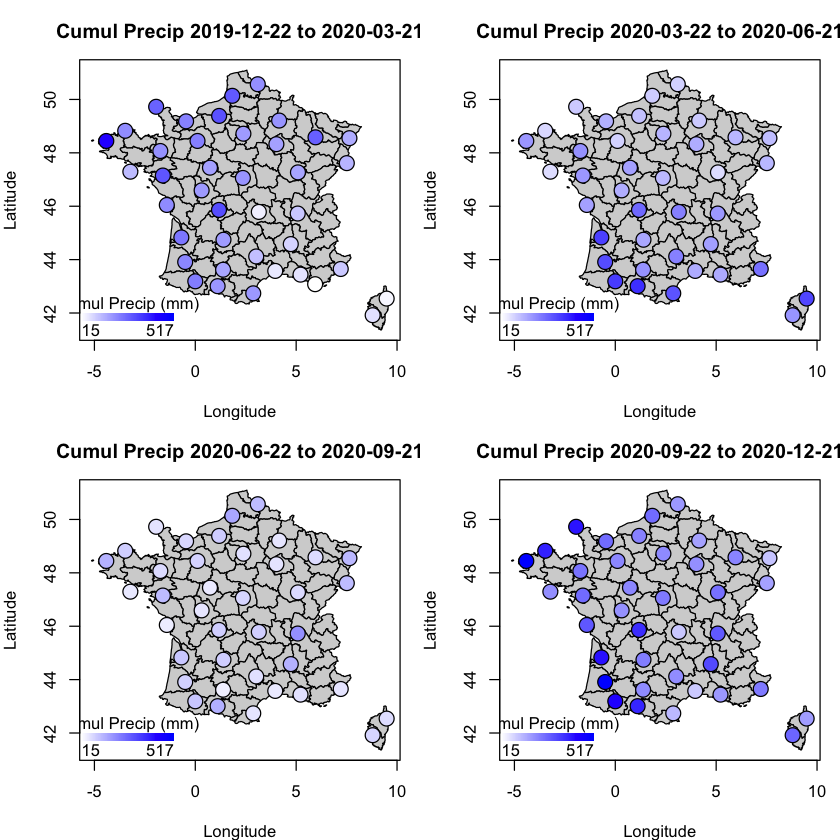

In [ ]:
# Graph cumulative precipitation over the seasons
dates <- list(
  c("2019-12-22", "2020-03-21"),
  c("2020-03-22", "2020-06-21"),
  c("2020-06-22", "2020-09-21"),
  c("2020-09-22", "2020-12-21")
)

# Colors for gradient
pal <- colorRampPalette(c("white", "blue"))
n_colors <- 200
colors <- pal(n_colors)

# Loading the french map
france_df <- map_data("france")
groups <- unique(france_df$group)

# Initialization of a memory
season_subset_data <- list()
measures_col <- c("Précipitations.dans.les.3.dernières.heures")

# Computing the data for each seasons
for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Filtering for this season
  up_to_date_data <- selected_data_maps[as_date(selected_data_maps$Date) >= as_date(date_inf) & as_date(selected_data_maps$Date) <= as_date(date_sup), ]

  # Building a new cumulative precipitation row that takes into account the missing data (if there's a 6h gap, we choose the 6h precipitation)
  # First grouping the up to date data by station, then working on the thing to choose the right precipitation value, then using summarise computing the sum and only keeping one date (cause they're all the same
  subset_data <- as.data.frame(up_to_date_data %>% 
                              group_by(Latitude, Longitude) %>% 
                              summarise(across(all_of(measures_col), sum), Date = first(Date), .groups = "drop"))
  season_subset_data[[i]] <- subset_data
}

# Building the color legend to have a common scale for the 4 plots
precipitation_range <- range(unlist(lapply(season_subset_data, function(df) df$Précipitations.dans.les.3.dernières.heures)))

# Colors for the legend
n_leg <- n_colors
leg_colors <- colors[1:n_leg]
precipitation_seq <- seq(min(precipitation_range), max(precipitation_range), length.out = n_leg)

# Plotting
par(mfrow = c(2,2), bg = "white", mar = c(4,4,3,1))

for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Loading the subset
  subset_data <- season_subset_data[[i]]

  # Associating a color to each data
  color_index <- round((subset_data$Précipitations.dans.les.3.dernières.heures - precipitation_range[1]) / 
                     (precipitation_range[2] - precipitation_range[1]) * (n_colors - 1)) + 1

  # Plotting France and points
  plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("Cumul Precip", date_inf, "to", date_sup)) # Outline 
  for(g in groups) { # Regions
    sub <- france_df[france_df$group == g, ]
    polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
  }

  points(subset_data$Longitude, subset_data$Latitude, bg = colors[color_index], col = "black", pch = 21, cex = 2) # Points

  # Adding the legend 
  usr <- par("usr")  # c(xmin, xmax, ymin, ymax)

  # Positioning the gradient in the bottom left 
  x0 <- usr[1] + 0.05 * (usr[2] - usr[1]) - 0.7
  x1 <- usr[1] + 0.25 * (usr[2] - usr[1]) + 0.7
  y0 <- usr[3] + 0.05 * (usr[4] - usr[3]) + 0.2
  y1 <- usr[3] + 0.08 * (usr[4] - usr[3]) + 0.2

  # Gradient
  dx <- (x1 - x0)/n_leg
  for(i in 1:n_leg){
    rect(x0 + (i-1)*dx, y0, x0 + i*dx, y1, col = leg_colors[i], border = NA)
  }

  # Adding labels
  text(x0, y0 - 0.03*(usr[4]-usr[3]), round(min(precipitation_seq),1), adj=0)
  text(x1, y0 - 0.03*(usr[4]-usr[3]), round(max(precipitation_seq),1), adj=1)
  text((x0+x1)/2, y1 + 0.03*(usr[4]-usr[3]), "Cumul Precip (mm)", adj=0.5)
}

#### Explanation
- What question am I asking about the data? What do I want to illustrate?
    - Finally we want to observe how varies the cumulative precipitation and again we use the same approach. To compute the cumulative 
- Why is the method I am going to use relevant?
    - We've chosen max wind because it clearly better captures extremes event than averages.
- What conclusions do I draw from it?
    - We clearly see extreme events, especially along the coast. There's also a trend across season, with much higher event during winter and fall.
- What are the possible limitations of what I am proposing?
    - Some data may be missing, and therefore when computing the sum to find the cumulative precipitation we sometimes sum 0mm 

## CLUSTERING 

In [ ]:
# Clustering spatially to search for sustainable agriculture spots (using Temperature, Precipitation, Humidity, Wind)
# Data will be averaged temporally be seasons
dates <- list(
  c("2019-12-22", "2020-03-21"),
  c("2020-03-22", "2020-06-21"),
  c("2020-06-22", "2020-09-21"),
  c("2020-09-22", "2020-12-21")
)

# Initialization of a memory
season_subset_data <- list()
hclust_results <- list()
measures_col <- c("Température", "Précipitations.dans.les.3.dernières.heures", "Humidité", "Vitesse.du.vent.moyen.10.mn")

# Computing the data for each seasons 
for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Filtering for this season
  up_to_date_data <- selected_data_maps[as_date(selected_data_maps$Date) >= as_date(date_inf) & as_date(selected_data_maps$Date) <= as_date(date_sup), ]

  # First grouping the up to date data by station, then using summarise computing the mean and only keeping one date (cause they're all the same
  subset_data <- as.data.frame(up_to_date_data %>% group_by(Latitude, Longitude) %>% summarise(across(all_of(measures_col), mean), Date = first(Date), .groups = "drop"))
  
  # Dropping the Date row
  subset_data <- subset_data %>% select(-"Date")
  season_subset_data[[i]] <- subset_data
}


# There's an extra point during winter, we remove it to have consistent data
station_lists <- lapply(season_subset_data, function(df) {
  df %>% select(Latitude, Longitude)
})

# Searching for common coordinates in all data frames
common_coords <- Reduce(function(x, y) inner_join(x, y, by = c("Latitude", "Longitude")), station_lists)

# And filtering to remove the extra point
season_subset_data <- lapply(season_subset_data, function(df) {
  inner_join(df, common_coords, by = c("Latitude", "Longitude"))
})

In [433]:
# CLUSTERING
# Using KMeans
nmb_clusters <- 4
for(i in seq_along(dates)){
  set.seed(123)  # For reproducibility 
  subset_data <- season_subset_data[[i]] %>% select(-c("Latitude", "Longitude"))
  kmeans_result <- kmeans(subset_data, centers = nmb_clusters)

  season_subset_data[[i]]$kmeans_cluster <- kmeans_result$cluster
}

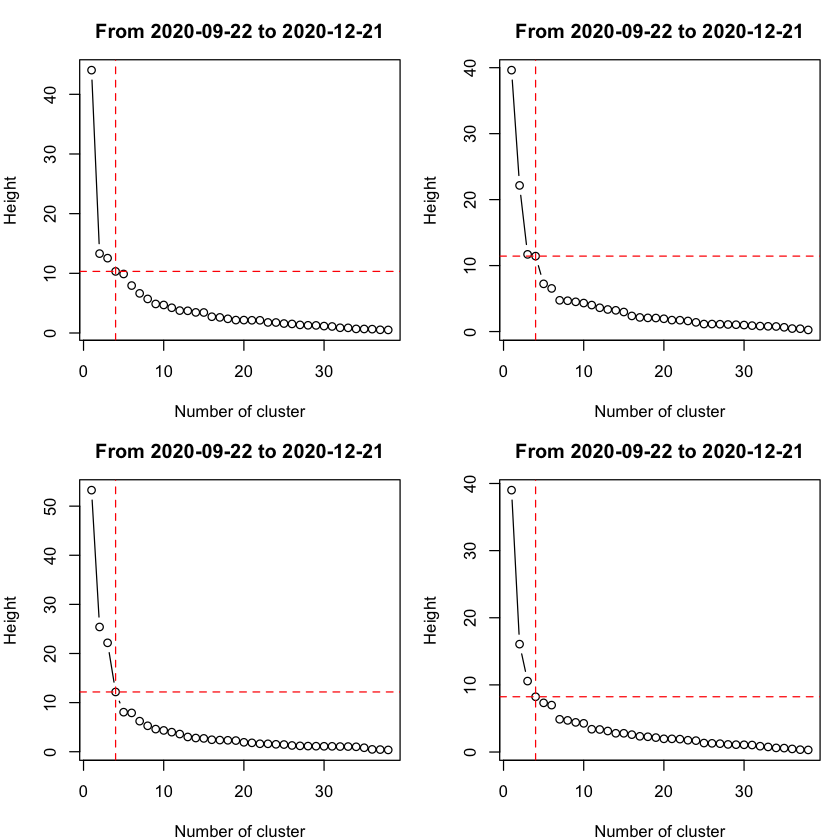

In [434]:
# Using Hierarchical Clustering
for(i in seq_along(dates)){
  subset_data <- season_subset_data[[i]] %>% select(-c("Latitude", "Longitude", "kmeans_cluster"))
  distances <- dist(subset_data)
  cah_data <- hclust(distances, method = "ward.D2")

  hclust_results[[i]] <- cah_data
}

# Plotting
par(mfrow = c(2,2), bg = "white", mar = c(4,4,3,1))

for(i in seq_along(dates)){
  cah_data <- hclust_results[[i]]
  plot(seq(length(cah_data$height),1), cah_data$height, xlab = "Number of cluster", ylab = "Height", type = "b", main = paste("From", date_inf, "to", date_sup))
  abline(v = nmb_clusters, col = "red", lty = 2, lwd = 1)
  abline(h = cah_data$height[length(cah_data$height) - nmb_clusters + 1], col = "red", lty = 2, lwd = 1)
}


We keep 5 clusters for hierarchical clustering, we keep this number fix for each season.

In [435]:
# Cutting the trees at 4 clusters
for(i in seq_along(dates)){
  cah_data <- hclust_results[[i]]  
  ind_cutree <- cutree(tree = cah_data, k = nmb_clusters)

  season_subset_data[[i]]$hclust_cluster <- ind_cutree
}

In [436]:
# Changing the index given by kmeans (only applying a permutation) to have a better mapping in the color during plotting
color_cluster_ref_kmeans <- season_subset_data[[1]]$kmeans_cluster
for(i in 2:4){
    current_table <- table(color_cluster_ref_kmeans, season_subset_data[[i]]$kmeans_cluster)
    current_mapping <- mapping <- solve_LSAP(current_table, maximum = TRUE)
    season_subset_data[[i]]$kmeans_cluster <- current_mapping[season_subset_data[[i]]$kmeans_cluster]
}

color_cluster_ref_hclust <- season_subset_data[[1]]$hclust_cluster
for(i in 2:4){
    current_table <- table(color_cluster_ref_hclust, season_subset_data[[i]]$hclust_cluster)
    current_mapping <- mapping <- solve_LSAP(current_table, maximum = TRUE)
    season_subset_data[[i]]$hclust_cluster <- current_mapping[season_subset_data[[i]]$hclust_cluster]
}

In [437]:
# Comparative table kmeans VS hclust
maps <- list()
for(i in seq_along(dates)){
    tab <- table(season_subset_data[[i]]$kmeans_cluster, season_subset_data[[i]]$hclust_cluster, dnn = c("kmeans", "hclust"))
    maps[[i]] <- mapping <- solve_LSAP(tab, maximum = TRUE)
    print(tab)
}

      hclust
kmeans  1  2  3  4
     1  0  0 16  2
     2  1  3  1  0
     3  0  0  2  7
     4  7  0  0  0
      hclust
kmeans  1  2  3  4
     1 13  0  0  1
     2  0  0  0  7
     3  0  7  0  0
     4  0  3  8  0
      hclust
kmeans  1  2  3  4
     1  0 15  0  1
     2  9  1  0  0
     3  0  0  3  0
     4  0  0  0 10
      hclust
kmeans  1  2  3  4
     1 20  0  0  0
     2  0  3  0  7
     3  3  0  0  0
     4  0  3  3  0


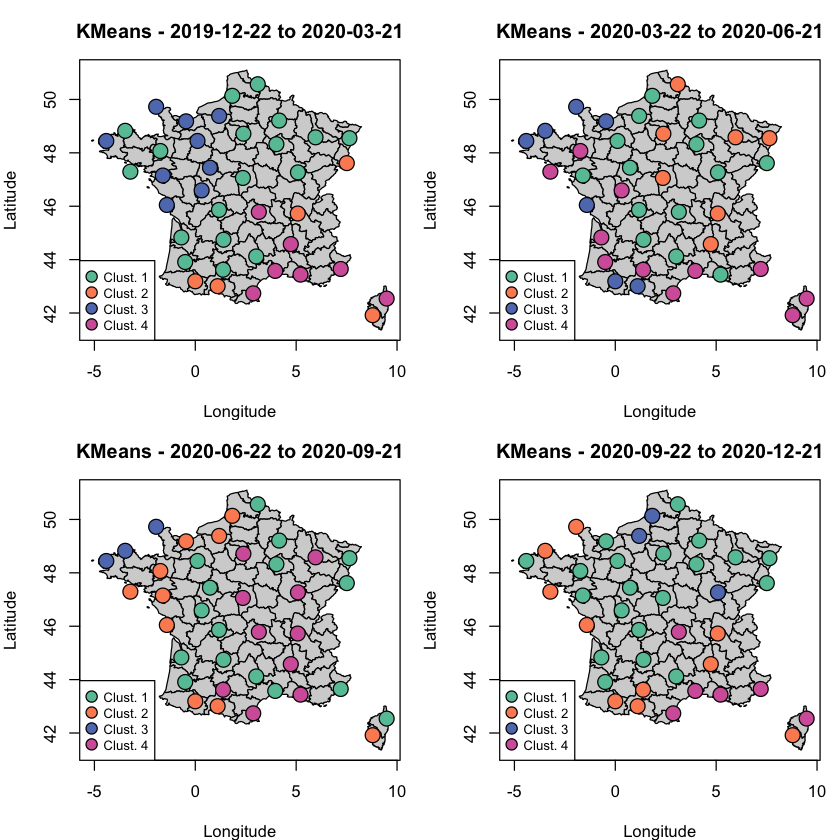

In [438]:
# PLOTTING KMeans
# Loading the french map
france_df <- map_data("france")
groups <- unique(france_df$group)

par(mfrow = c(2,2), bg = "white", mar = c(4,4,3,1))
cluster_colors <- c("#66c2a5", "#fc8d62", "#607cbcff", "#d563a9ff") #  "#789d3cff"

for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Loading the subset
  subset_data <- season_subset_data[[i]]

  # Plotting France and points
  plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("KMeans -", date_inf, "to", date_sup)) # Outline 
  for(g in groups) { # Regions
    sub <- france_df[france_df$group == g, ]
    polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
  }

  points(subset_data$Longitude, subset_data$Latitude, bg = cluster_colors[subset_data$kmeans_cluster], col = "black", pch = 21, cex = 2) # Points

  # Adding legend
  legend("bottomleft", legend = paste("Clust.", 1:length(cluster_colors)), 
         pt.bg = cluster_colors, pch = 21, pt.cex = 1.5, cex = 0.8)
}

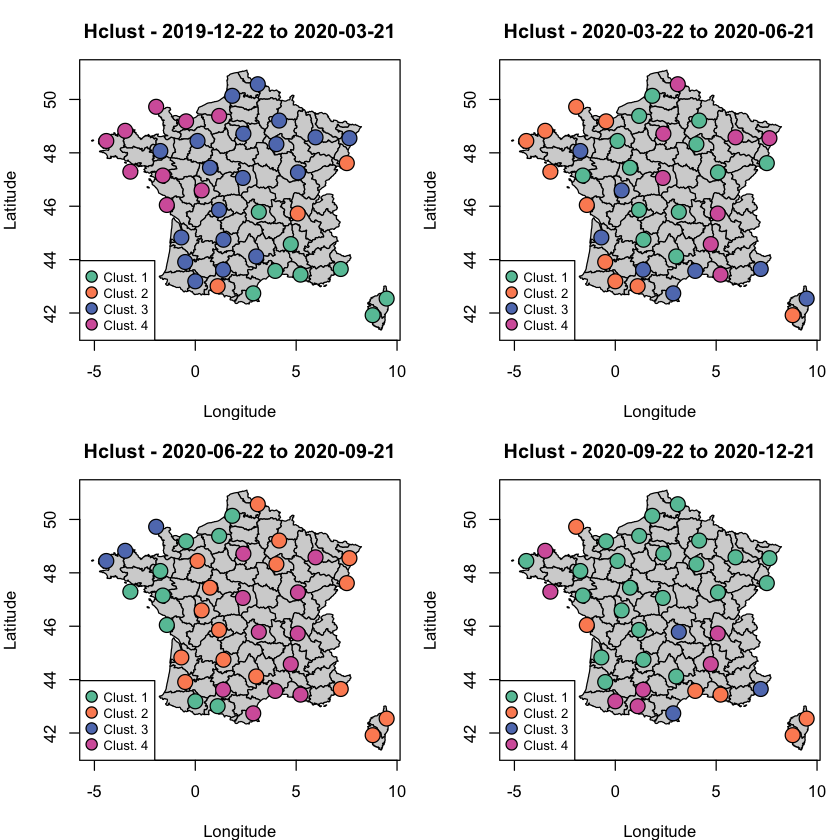

In [439]:
# PLOTTING HClust
# Loading the french map
france_df <- map_data("france")
groups <- unique(france_df$group)

par(mfrow = c(2,2), bg = "white", mar = c(4,4,3,1))
cluster_colors <- c("#66c2a5", "#fc8d62", "#607cbcff", "#d563a9ff") # "#789d3cff"

for(i in seq_along(dates)){
  date_inf <- dates[[i]][1]
  date_sup <- dates[[i]][2]

  # Loading the subset
  subset_data <- season_subset_data[[i]]

  # Plotting France and points
  plot(france_df$long, france_df$lat, xlab = "Longitude", ylab = "Latitude", type = "n", main = paste("Hclust -", date_inf, "to", date_sup)) # Outline 
  for(g in groups) { # Regions
    sub <- france_df[france_df$group == g, ]
    polygon(sub$long, sub$lat, col = "lightgrey", border = "black")
  }

  points(subset_data$Longitude, subset_data$Latitude, bg = cluster_colors[subset_data$hclust_cluster], col = "black", pch = 21, cex = 2) # Points
  
  # Adding legend
  legend("bottomleft", legend = paste("Clust.", 1:length(cluster_colors)), 
         pt.bg = cluster_colors, pch = 21, pt.cex = 1.5, cex = 0.8)
}